In [2]:
import sys

import numpy as np

sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")

In [4]:
dataprep = DataPreparation(train, 0.3)
train_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅
Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 4/4 [01:15<00:00, 18.79s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 
Variables catégorielles discrétisées ✅


In [25]:
train_prepared.to_csv("../data/train_prepared_70.csv")
test_prepared.to_csv("../data/test_prepared_70.csv")
#train_prepared = pd.read_csv("../data/train_preparedV2.csv", index_col=[0])
#test_prepared = pd.read_csv("../data/test_preparedv2.csv", index_col=[0])

In [5]:
df_train = train_prepared.iloc[:280000,:]
df_test = train_prepared.iloc[280000:,:]

# Modélisation

In [21]:
features = ['REGION_RATING_CLIENT_W_CITY', 'DAYS_CREDIT_ENDDATE_disc_int', 'RATE_DOWN_PAYMENT_disc_int', 'AMT_PAYMENT_disc_int', 'NAME_INCOME_TYPE_discret', 'OCCUPATION_TYPE_discret']

In [22]:
train_prepared[features]

,REGION_RATING_CLIENT_W_CITY,DAYS_CREDIT_ENDDATE_disc_int,RATE_DOWN_PAYMENT_disc_int,AMT_PAYMENT_disc_int,NAME_INCOME_TYPE_discret,OCCUPATION_TYPE_discret
0,trois,[-58.0;214193.0],[-0.0;0.21],[148458.51;25537053.78],high_income,low_skilled
1,trois,[-155271.0;-59.0],[-0.0;0.21],[148458.51;25537053.78],high_income,low_skilled
2,un_deux,[-58.0;214193.0],[-0.0;0.21],[0.0;148457.61],high_income,low_skilled
3,un_deux,[-155271.0;-59.0],[-0.0;0.21],[0.0;148457.61],high_income,low_skilled
4,un_deux,[-58.0;214193.0],[-0.0;0.21],[0.0;148457.61],high_income,low_skilled
...,...,...,...,...,...,...
306102,trois,[-58.0;214193.0],[-0.0;0.21],[0.0;148457.61],other,low_skilled
306103,un_deux,[-155271.0;-59.0],[0.21;4.48],[148458.51;25537053.78],high_income,low_skilled
306104,un_deux,[-58.0;214193.0],[-0.0;0.21],[0.0;148457.61],high_income,low_skilled
306105,trois,[-58.0;214193.0],[-0.0;0.21],[0.0;148457.61],other,low_skilled


In [23]:
reference_categories = {
    'REGION_RATING_CLIENT_W_CITY' : "un_deux",
    'DAYS_CREDIT_ENDDATE_disc_int' : "[-155271.0;-59.0]",
    'RATE_DOWN_PAYMENT_disc_int' : "[0.21;4.48]",
    'AMT_PAYMENT_disc_int' : "[148458.51;25537053.78]",
    'NAME_INCOME_TYPE_discret' : "other",
    'OCCUPATION_TYPE_discret' : "high_skilled",
    'NAME_CONTRACT_TYPE' : "Revolving loans"
}


In [24]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [25]:
model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.261441
         Iterations 7


# Prédiction

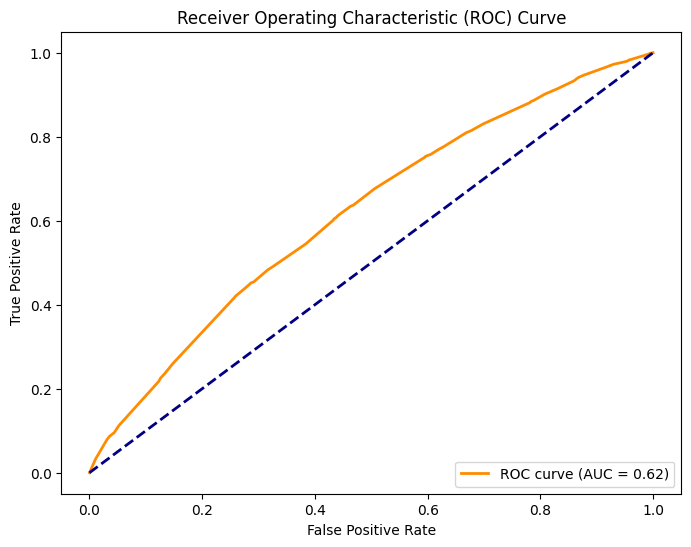

0.23540347744736412

In [26]:
pred = logit_model.predict(df_test)
fpr, tpr, thresholds = roc_curve(df_test["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

# Grille de score

In [27]:
GS = GridScore(train_prepared, logit_model)
grid_score = GS.compute_grid_score()

In [28]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-3.870713,0.0,0.000000,0.0,0.00,0.00
1,REGION_RATING_CLIENT_W_CITY,un_deux_ref,0.000000,0.0,200.000000,20.0,6.13,85.76
2,REGION_RATING_CLIENT_W_CITY,trois,0.470000,0.0,0.000000,20.0,1.55,14.24
3,DAYS_CREDIT_ENDDATE_disc_int,[-155271.0;-59.0]_ref,0.000000,0.0,195.744681,20.0,2.75,47.00
4,DAYS_CREDIT_ENDDATE_disc_int,[-58.0;214193.0],0.460000,0.0,0.000000,20.0,4.92,53.00
5,RATE_DOWN_PAYMENT_disc_int,[0.21;4.48]_ref,0.000000,0.0,106.382979,11.0,1.92,31.04
6,RATE_DOWN_PAYMENT_disc_int,[-0.0;0.21],0.250000,0.0,0.000000,11.0,5.75,68.96
7,AMT_PAYMENT_disc_int,[148458.51;25537053.78]_ref,0.000000,0.0,80.851064,8.0,4.80,67.93
8,AMT_PAYMENT_disc_int,[0.0;148457.61],0.190000,0.0,0.000000,8.0,2.87,32.07
9,NAME_INCOME_TYPE_discret,other_ref,0.000000,0.0,234.042553,23.0,1.31,25.11


## Calcul des scores individuels

In [29]:
df_score = GS.get_individual_score()

(array([ 3828.,     0.,  5819.,   737.,     0.,  6259., 22406.,  3152.,
        39510.,  8437.,   211., 45618.,  2401., 20076., 30021., 20266.,
         2587., 30933., 14239.,  8963.,  4528., 14448.,  8344.,     0.,
         9541.,     0.,  2014.,   353.,     0.,  1416.]),
 array([   0.        ,   33.33333333,   66.66666667,  100.        ,
         133.33333333,  166.66666667,  200.        ,  233.33333333,
         266.66666667,  300.        ,  333.33333333,  366.66666667,
         400.        ,  433.33333333,  466.66666667,  500.        ,
         533.33333333,  566.66666667,  600.        ,  633.33333333,
         666.66666667,  700.        ,  733.33333333,  766.66666667,
         800.        ,  833.33333333,  866.66666667,  900.        ,
         933.33333333,  966.66666667, 1000.        ]),
 <BarContainer object of 30 artists>)

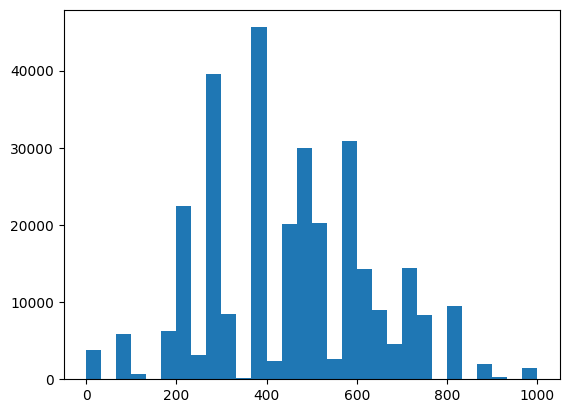

In [33]:
plt.hist(df_score["Score_ind"], bins=30)

In [31]:
df_score.to_csv("../data/df_score.csv")